In [17]:
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [18]:

# Load AAPL Stock Data
stock_data = yf.download('AAPL', start='2023-01-01', end='2024-01-10')['Close'].values
# len(stock_data.tolist())= 256

[*********************100%%**********************]  1 of 1 completed


In [19]:

# Normalize the stock prices
min_price, max_price = stock_data.min(), stock_data.max()
normalized_data = (stock_data - min_price) / (max_price - min_price)


In [20]:

# Prepare data tensors
true_data = torch.tensor(normalized_data, dtype=torch.float32)
train_data = true_data[:250]  # Input for the Generator
target_data = true_data  # Full target data

# Now, true_data has size 
print(f"true_data has size {true_data.size()}, train_data has size {train_data.size()}, target_data has size {target_data.size()}")


true_data has size torch.Size([256]), train_data has size torch.Size([250]), target_data has size torch.Size([256])


In [21]:
true_data.size()
# So now the new 375 = 256 and the new 365 = 250

torch.Size([256])

In [22]:

class Generator(nn.Module):
    def __init__(self, input_dim=250, output_dim=256):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.Tanh()
        )
    
    def forward(self, x):
        print(f"Generator input shape: {x.shape}")  # Debug log
        output = self.net(x)
        print(f"Generator output shape: {output.shape}")  # Debug log
        return output


In [23]:

class Discriminator(nn.Module):
    def __init__(self, input_dim=256):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1)
        )
    
    def forward(self, x):
        print(f"Discriminator input shape: {x.shape}")  # Debug log
        output = self.net(x)
        print(f"Discriminator output shape: {output.shape}")  # Debug log
        return output


In [24]:

# Initialize models
generator = Generator()
discriminator = Discriminator()


In [25]:

# Optimizers
optimizer_G = optim.RMSprop(generator.parameters(), lr=0.0001)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=0.0001)


In [26]:

# Loss functions for Wasserstein GAN
def discriminator_loss(real_output, fake_output):
    return -torch.mean(real_output) + torch.mean(fake_output)

def generator_loss(fake_output):
    return -torch.mean(fake_output)


In [27]:
train_data.size()

torch.Size([250])

In [34]:

# Training loop
epochs = 50
critic_iterations = 5

for epoch in range(epochs):
    for _ in range(critic_iterations):
        optimizer_D.zero_grad()
        
        # Real and fake data
        real_data = target_data.unsqueeze(0)  # Shape (1, 256)
        fake_data = generator(train_data.unsqueeze(0)).detach()  # Shape (1, 250 -> 256)
        
        # Discriminator outputs
        real_output = discriminator(real_data)
        fake_output = discriminator(fake_data)
        
        # Compute Discriminator loss
        loss_d = discriminator_loss(real_output, fake_output)
        loss_d.backward()
        optimizer_D.step()

    # Train Generator
    optimizer_G.zero_grad()
    fake_data = generator(train_data.unsqueeze(0))  # Shape (1, 250 -> 256)
    fake_output = discriminator(fake_data)
    loss_g = generator_loss(fake_output)
    loss_g.backward()
    optimizer_G.step()

    # Print logs every 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")


Generator input shape: torch.Size([1, 250])
Generator output shape: torch.Size([1, 256])
Discriminator input shape: torch.Size([1, 256])
Discriminator output shape: torch.Size([1, 1])
Discriminator input shape: torch.Size([1, 256])
Discriminator output shape: torch.Size([1, 1])
Generator input shape: torch.Size([1, 250])
Generator output shape: torch.Size([1, 256])
Discriminator input shape: torch.Size([1, 256])
Discriminator output shape: torch.Size([1, 1])
Discriminator input shape: torch.Size([1, 256])
Discriminator output shape: torch.Size([1, 1])
Generator input shape: torch.Size([1, 250])
Generator output shape: torch.Size([1, 256])
Discriminator input shape: torch.Size([1, 256])
Discriminator output shape: torch.Size([1, 1])
Discriminator input shape: torch.Size([1, 256])
Discriminator output shape: torch.Size([1, 1])
Generator input shape: torch.Size([1, 250])
Generator output shape: torch.Size([1, 256])
Discriminator input shape: torch.Size([1, 256])
Discriminator output shape

Generator input shape: torch.Size([1, 250])
Generator output shape: torch.Size([1, 256])


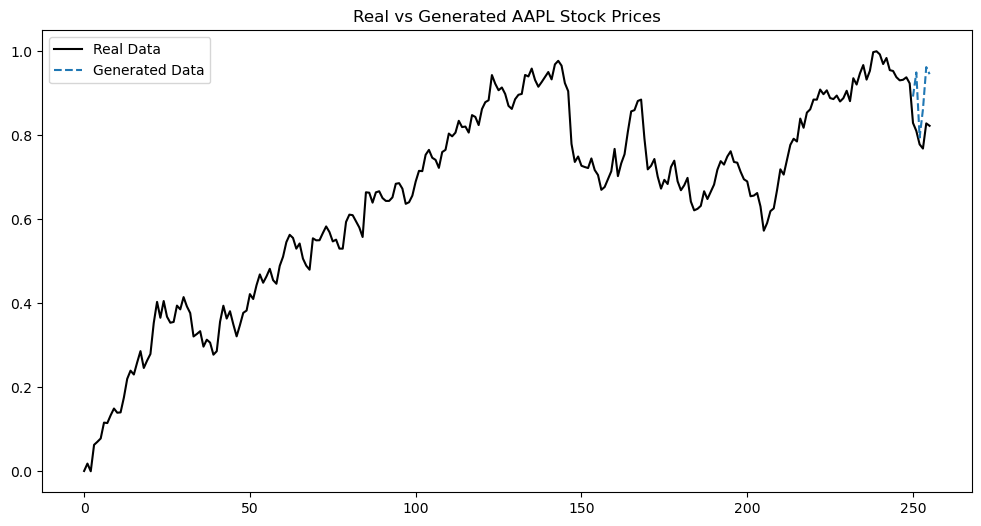

In [35]:

# Plot results
generated_stock = generator(train_data.unsqueeze(0)).detach().numpy()[0]
real_stock = target_data.numpy()

plt.figure(figsize=(12, 6))
plt.plot(range(256), real_stock, label='Real Data', color='black')
plt.plot(range(250, 256), generated_stock[250:], label='Generated Data', linestyle='dashed')
plt.legend()
plt.title('Real vs Generated AAPL Stock Prices')
plt.show()
